In [1]:
import sys
import os
import numpy as np
import pandas as pd
import papermill as pm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import tensorflow as tf
import tensorflow.keras as keras

from recommenders.utils.timer import Timer
from recommenders.datasets import movielens
from recommenders.datasets.split_utils import min_rating_filter_pandas
from recommenders.datasets.python_splitters import numpy_stratified_split
from recommenders.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k
from recommenders.datasets.pandas_df_utils import filter_by, negative_feedback_sampler

from recommenders.datasets.sparse import AffinityMatrix
from recommenders.utils.python_utils import binarize
from recommenders.models.vae.multinomial_vae import Mult_VAE

from tempfile import TemporaryDirectory

print("System version: {}".format(sys.version))
print("Pandas version: {}".format(pd.__version__))
print("Tensorflow version: {}".format(tf.__version__))
print("Keras version: {}".format(keras.__version__))

System version: 3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0]
Pandas version: 1.4.1
Tensorflow version: 2.2.0
Keras version: 2.3.0-tf


In [2]:
# top k items to recommend
TOP_K = 10

# Select MovieLens data size: 100k, 1m, 10m, or 20m
MOVIELENS_DATA_SIZE = '1m'

# Model parameters
HELDOUT_USERS = 600 # CHANGE FOR DIFFERENT DATASIZE
INTERMEDIATE_DIM = 200
LATENT_DIM = 70
EPOCHS = 20
BATCH_SIZE = 100

# temporary Path to save the optimal model's weights
tmp_dir = TemporaryDirectory()
WEIGHTS_PATH = os.path.join(tmp_dir.name, "mvae_weights.hdf5")

SEED = 98765

In [3]:
COL_USER = "userID"
COL_ITEM = "itemID"
COL_RATING = "rating"
COL_PREDICTION = "rating"
COL_TIMESTAMP = "timestamp"

root_dir = '/opt/ml/input/data/train/'
df = pd.read_csv(os.path.join(root_dir,'train_ratings.csv'), names=[COL_USER, COL_ITEM, COL_TIMESTAMP], header=0)
df.head()

,userID,itemID,timestamp
0,11,4643,1230782529
1,11,170,1230782534
2,11,531,1230782539
3,11,616,1230782542
4,11,2140,1230782563


In [4]:
df.shape

(5154471, 3)

In [5]:
# df['rating'] = 1
negative_sampling = negative_feedback_sampler(df[[COL_USER, COL_ITEM]], col_user=COL_USER, col_item=COL_ITEM)
negative_sampling.head()

,userID,itemID,feedback
0,11,4643,1
1,11,170,1
2,11,531,1
3,11,616,1
4,11,2140,1


In [6]:
df = negative_sampling
df.rename(columns = {"feedback": "rating"}, inplace=True)

In [7]:
# Obtain both usercount and itemcount after filtering
usercount = df[['userID']].groupby('userID', as_index = False).size()
itemcount = df[['itemID']].groupby('itemID', as_index = False).size()

# Compute sparsity after filtering
sparsity = 1. * df.shape[0] / (usercount.shape[0] * itemcount.shape[0])

print("After filtering, there are %d watching events from %d users and %d movies (sparsity: %.3f%%)" % 
      (df.shape[0], usercount.shape[0], itemcount.shape[0], sparsity * 100))

After filtering, there are 10308942 watching events from 31360 users and 6807 movies (sparsity: 4.829%)


## Data filtering

In [8]:
# Binarize the data (only keep ratings >= 4)
df_preferred = df[df['rating'] > 0.5]
print (df_preferred.shape)
df_low_rating = df[df['rating'] <= 0.5]


# df.head()
df_preferred.head(10)

(5154471, 3)


,userID,itemID,rating
0,11,4643,1
1,11,170,1
2,11,531,1
3,11,616,1
4,11,2140,1
5,11,2722,1
6,11,2313,1
7,11,2688,1
8,11,2428,1
9,11,3113,1


In [9]:
# Keep users who clicked on at least 5 movies
df = min_rating_filter_pandas(df_preferred, min_rating=5, filter_by="user")

# Keep movies that were clicked on by at least on 1 user
df = min_rating_filter_pandas(df, min_rating=1, filter_by="item")

In [10]:
# Obtain both usercount and itemcount after filtering
usercount = df[['userID']].groupby('userID', as_index = False).size()
itemcount = df[['itemID']].groupby('itemID', as_index = False).size()

# Compute sparsity after filtering
sparsity = 1. * df.shape[0] / (usercount.shape[0] * itemcount.shape[0])

print("After filtering, there are %d watching events from %d users and %d movies (sparsity: %.3f%%)" % 
      (df.shape[0], usercount.shape[0], itemcount.shape[0], sparsity * 100))

After filtering, there are 5154471 watching events from 31360 users and 6807 movies (sparsity: 2.415%)


In [11]:
unique_users = sorted(df.userID.unique())
np.random.seed(SEED)
unique_users = np.random.permutation(unique_users)

In [12]:
# Create train/validation/test users
n_users = len(unique_users)
print("Number of unique users:", n_users)

train_users = unique_users[:(n_users - HELDOUT_USERS * 2)]
print("\nNumber of training users:", len(train_users))

val_users = unique_users[(n_users - HELDOUT_USERS * 2) : (n_users - HELDOUT_USERS)]
print("\nNumber of validation users:", len(val_users))

test_users = unique_users[(n_users - HELDOUT_USERS):]
print("\nNumber of test users:", len(test_users))

Number of unique users: 31360

Number of training users: 30160

Number of validation users: 600

Number of test users: 600


In [13]:
# For training set keep only users that are in train_users list
train_set = df.loc[df['userID'].isin(train_users)]
print("Number of training observations: ", train_set.shape[0])

# For validation set keep only users that are in val_users list
val_set = df.loc[df['userID'].isin(val_users)]
print("\nNumber of validation observations: ", val_set.shape[0])

# For test set keep only users that are in test_users list
test_set = df.loc[df['userID'].isin(test_users)]
print("\nNumber of test observations: ", test_set.shape[0])

# train_set/val_set/test_set contain user - movie interactions with rating 4 or 5

Number of training observations:  4956566

Number of validation observations:  97682

Number of test observations:  100223


In [14]:
# Obtain list of unique movies used in training set
unique_train_items = pd.unique(train_set['itemID'])
print("Number of unique movies that rated in training set", unique_train_items.size)

Number of unique movies that rated in training set 6807


In [15]:
# For validation set keep only movies that used in training set
val_set = val_set.loc[val_set['itemID'].isin(unique_train_items)]
print("Number of validation observations after filtering: ", val_set.shape[0])

# For test set keep only movies that used in training set
test_set = test_set.loc[test_set['itemID'].isin(unique_train_items)]
print("\nNumber of test observations after filtering: ", test_set.shape[0])

Number of validation observations after filtering:  97682

Number of test observations after filtering:  100223


# Click matrix generation

In [16]:
# Instantiate the sparse matrix generation for train, validation and test sets
# use list of unique items from training set for all sets
am_train = AffinityMatrix(df=train_set, items_list=unique_train_items)

am_val = AffinityMatrix(df=val_set, items_list=unique_train_items)

am_test = AffinityMatrix(df=test_set, items_list=unique_train_items)

In [17]:
# Obtain the sparse matrix for train, validation and test sets
train_data, _, _ = am_train.gen_affinity_matrix()
print(train_data.shape)

val_data, val_map_users, val_map_items = am_val.gen_affinity_matrix()
print(val_data.shape)

test_data, test_map_users, test_map_items = am_test.gen_affinity_matrix()
print(test_data.shape)

(30160, 6807)
(600, 6807)
(600, 6807)


In [18]:
# Split validation and test data into training and testing parts
val_data_tr, val_data_te = numpy_stratified_split(val_data, ratio=0.75, seed=SEED)
test_data_tr, test_data_te = numpy_stratified_split(test_data, ratio=0.75, seed=SEED)

In [19]:
# Binarize train, validation and test data
train_data = binarize(a=train_data, threshold=0.5)
val_data = binarize(a=val_data, threshold=0.5)
test_data = binarize(a=test_data, threshold=0.5)

In [20]:
# Binarize validation data: training part  
val_data_tr = binarize(a=val_data_tr, threshold=0.5)

# Binarize validation data: testing part (save non-binary version in the separate object, will be used for calculating NDCG)
val_data_te_ratings = val_data_te.copy()
val_data_te = binarize(a=val_data_te, threshold=0.5)

In [21]:
# Binarize test data: training part 
test_data_tr = binarize(a=test_data_tr, threshold=0.5)

# Binarize test data: testing part (save non-binary version in the separate object, will be used for calculating NDCG)
test_data_te_ratings = test_data_te.copy()
test_data_te = binarize(a=test_data_te, threshold=0.5)

In [22]:
# retrieve real ratings from initial dataset 

test_data_te_ratings=pd.DataFrame(test_data_te_ratings)
val_data_te_ratings=pd.DataFrame(val_data_te_ratings)

for index,i in df_low_rating.iterrows():
    user_old= i['userID'] # old value 
    item_old=i['itemID'] # old value 

    if (test_map_users.get(user_old) is not None)  and (test_map_items.get(item_old) is not None) :
        user_new=test_map_users.get(user_old) # new value 
        item_new=test_map_items.get(item_old) # new value 
        rating=i['rating'] 
        test_data_te_ratings.at[user_new,item_new]= rating   

    if (val_map_users.get(user_old) is not None)  and (val_map_items.get(item_old) is not None) :
        user_new=val_map_users.get(user_old) # new value 
        item_new=val_map_items.get(item_old) # new value 
        rating=i['rating'] 
        val_data_te_ratings.at[user_new,item_new]= rating   


val_data_te_ratings=val_data_te_ratings.to_numpy()    
test_data_te_ratings=test_data_te_ratings.to_numpy()    
# test_data_te_ratings  

In [23]:
# Just checking
print(np.sum(val_data))
print(np.sum(val_data_tr))
print(np.sum(val_data_te))

97682.0
73261.0
24421.0


In [24]:
# Just checking
print(np.sum(test_data))
print(np.sum(test_data_tr))
print(np.sum(test_data_te))

100223.0
75152.0
25071.0


In [25]:
from tqdm import tqdm

# Train

In [26]:
# import tensorflow as tf

In [27]:
# os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

In [28]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [29]:
model_without_anneal = Mult_VAE(n_users=train_data.shape[0], # Number of unique users in the training set
                                original_dim=train_data.shape[1], # Number of unique items in the training set
                                intermediate_dim=INTERMEDIATE_DIM, 
                                latent_dim=LATENT_DIM, 
                                n_epochs=EPOCHS, 
                                batch_size=BATCH_SIZE, 
                                k=TOP_K,
                                verbose=1,
                                seed=SEED,
                                save_path=WEIGHTS_PATH,
                                drop_encoder=0.5,
                                drop_decoder=0.5,
                                annealing=False,
                                beta=1.0
                                )

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [30]:
with Timer() as t:
    model_without_anneal.fit(x_train=train_data, 
                             x_valid=val_data, 
                             x_val_tr=val_data_tr, 
                             x_val_te=val_data_te_ratings, 
                             mapper=am_val
                             )
print("Took {} seconds for training.".format(t))

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20


2022-04-02 13:16:04.838274: I tensorflow/core/common_runtime/process_util.cc:147] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


301/301 [==============================] - 14s 46ms/step - loss: 1279.7904 - val_loss: 1226.5083 - lr: 0.0010
Epoch 2/20
301/301 [==============================] - 12s 38ms/step - loss: 1237.6847 - val_loss: 1209.0308 - lr: 0.0010
Epoch 3/20
301/301 [==============================] - 12s 39ms/step - loss: 1224.3921 - val_loss: 1197.8536 - lr: 0.0010
Epoch 4/20
301/301 [==============================] - 9s 29ms/step - loss: 1216.9961 - val_loss: 1191.3636 - lr: 0.0010
Epoch 5/20
301/301 [==============================] - 8s 28ms/step - loss: 1211.3675 - val_loss: 1185.0664 - lr: 0.0010
Epoch 6/20
301/301 [==============================] - 8s 28ms/step - loss: 1207.0368 - val_loss: 1182.0608 - lr: 0.0010
Epoch 7/20
301/301 [==============================] - 10s 34ms/step - loss: 1203.8075 - val_loss: 1179.0434 - lr: 0.0010
Epoch 8/20
301/301 [==============================] - 10s 32ms/step - loss: 1200.9837 - val_loss: 1176.8874 - lr: 0.0010
Epoch 9/20
301/301 [==========================

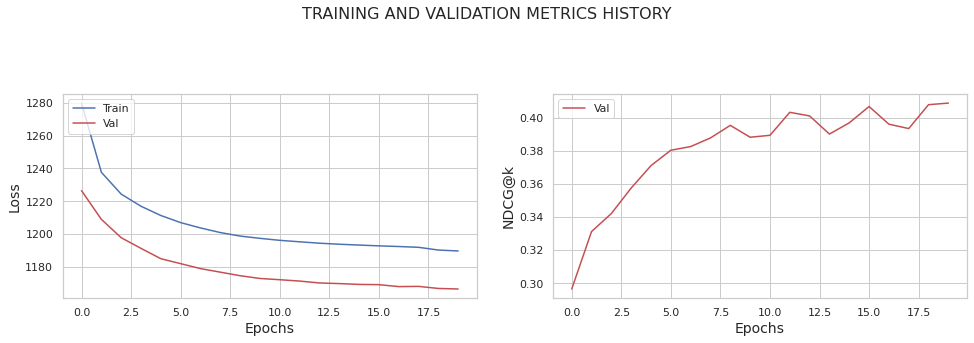

In [31]:
model_without_anneal.display_metrics()

In [37]:
ndcg_val_without_anneal = model_without_anneal.ndcg_per_epoch()

In [33]:
# Use k = 10
with Timer() as t:
    # Model prediction on the training part of test set 
    top_k =  model_without_anneal.recommend_k_items(x=test_data_tr,
                                                    k=10,
                                                    remove_seen=True
                                                    )

    # Convert sparse matrix back to df
    top_k_df = am_test.map_back_sparse(top_k, kind='prediction')
    test_df = am_test.map_back_sparse(test_data_te_ratings, kind='ratings') # use test_data_te_, with the original ratings
    
print("Took {} seconds for prediction.".format(t))

# Use the ranking metrics for evaluation
eval_map_1 = map_at_k(test_df, top_k_df, col_prediction='prediction', k=10)
eval_ndcg_1 = ndcg_at_k(test_df, top_k_df, col_prediction='prediction', k=10)
eval_precision_1 = precision_at_k(test_df, top_k_df, col_prediction='prediction', k=10)
eval_recall_1 = recall_at_k(test_df, top_k_df, col_prediction='prediction', k=10)

print("MAP@10:\t\t%f" % eval_map_1,
      "NDCG@10:\t%f" % eval_ndcg_1,
      "Precision@10:\t%f" % eval_precision_1,
      "Recall@10: \t%f" % eval_recall_1, sep='\n')

Took 0.8519 seconds for prediction.
MAP@10:		0.070929
NDCG@10:	0.395495
Precision@10:	0.367667
Recall@10: 	0.109014


In [48]:
top_k_df

,userID,itemID,prediction
0,168,32,4.620585
1,168,1214,4.020807
2,168,1270,4.329966
3,168,541,4.109946
4,168,7361,5.349957
...,...,...,...
59995,138157,48780,4.407296
59996,138157,68954,4.851802
59997,138157,5989,4.239973
59998,138157,4963,4.502749


In [34]:
with Timer() as t:
    # Model prediction on the training part of test set 
    TOP_K = 100
    top_k =  model_without_anneal.recommend_k_items(x=test_data_tr,
                                                    k=TOP_K,
                                                    remove_seen=True
                                                    )
    # Convert sparse matrix back to df
    top_k_df = am_test.map_back_sparse(top_k, kind='prediction')
    test_df = am_test.map_back_sparse(test_data_te_ratings, kind='ratings') # use test_data_te_, with the original ratings
    
print("Took {} seconds for prediction.".format(t))

# Use the ranking metrics for evaluation
eval_map_2 = map_at_k(test_df, top_k_df, col_prediction='prediction', k=TOP_K)
eval_ndcg_2 = ndcg_at_k(test_df, top_k_df, col_prediction='prediction', k=TOP_K)
eval_precision_2 = precision_at_k(test_df, top_k_df, col_prediction='prediction', k=TOP_K)
eval_recall_2 = recall_at_k(test_df, top_k_df, col_prediction='prediction', k=TOP_K)

print("MAP@100:\t%f" % eval_map_2,
      "NDCG@100:\t%f" % eval_ndcg_2,
      "Precision@100:\t%f" % eval_precision_2,
      "Recall@100: \t%f" % eval_recall_2, sep='\n')

Took 1.6865 seconds for prediction.
MAP@100:	0.165896
NDCG@100:	0.401493
Precision@100:	0.167667
Recall@100: 	0.451746


# Inference

In [35]:
COL_USER = "userID"
COL_ITEM = "itemID"
COL_RATING = "rating"
COL_PREDICTION = "rating"
COL_TIMESTAMP = "timestamp"

root_dir = '/opt/ml/input/data/train/'
df = pd.read_csv(os.path.join(root_dir,'train_ratings.csv'), names=[COL_USER, COL_ITEM, COL_TIMESTAMP], header=0)
df.head()

,userID,itemID,timestamp
0,11,4643,1230782529
1,11,170,1230782534
2,11,531,1230782539
3,11,616,1230782542
4,11,2140,1230782563


In [36]:
df = df[['userID', 'itemID']]
df['rating'] = 1

In [37]:
df.rename(columns = {"feedback": "rating"}, inplace=True)

In [38]:
# top k items to recommend
TOP_K = 10

# Select MovieLens data size: 100k, 1m, 10m, or 20m
MOVIELENS_DATA_SIZE = '1m'

# Model parameters
HELDOUT_USERS = 31360 # CHANGE FOR DIFFERENT DATASIZE
INTERMEDIATE_DIM = 200
LATENT_DIM = 70
EPOCHS = 20
BATCH_SIZE = 100

# temporary Path to save the optimal model's weights

SEED = 98765

In [39]:
# Create train/validation/test users
n_users = len(unique_users)
print("Number of unique users:", n_users)

train_users = unique_users[:(n_users - HELDOUT_USERS * 2)]
print("\nNumber of training users:", len(train_users))

val_users = unique_users[(n_users - HELDOUT_USERS * 2) : (n_users - HELDOUT_USERS)]
print("\nNumber of validation users:", len(val_users))

test_users = unique_users[(n_users - HELDOUT_USERS):]
print("\nNumber of test users:", len(test_users))

Number of unique users: 31360

Number of training users: 0

Number of validation users: 0

Number of test users: 31360


In [40]:
# For training set keep only users that are in train_users list
train_set = df.loc[df['userID'].isin(train_users)]
print("Number of training observations: ", train_set.shape[0])

# For validation set keep only users that are in val_users list
val_set = df.loc[df['userID'].isin(val_users)]
print("\nNumber of validation observations: ", val_set.shape[0])

# For test set keep only users that are in test_users list
test_set = df.loc[df['userID'].isin(test_users)]
print("\nNumber of test observations: ", test_set.shape[0])

# train_set/val_set/test_set contain user - movie interactions with rating 4 or 5

Number of training observations:  0

Number of validation observations:  0

Number of test observations:  5154471


In [41]:
# Obtain list of unique movies used in training set
# unique_train_items = pd.unique(train_set['itemID'])
unique_train_items = pd.unique(test_set['itemID'])
print("Number of unique movies that rated in training set", unique_train_items.size)

Number of unique movies that rated in training set 6807


In [42]:
# For validation set keep only movies that used in training set
val_set = val_set.loc[val_set['itemID'].isin(unique_train_items)]
print("Number of validation observations after filtering: ", val_set.shape[0])

# For test set keep only movies that used in training set
test_set = test_set.loc[test_set['itemID'].isin(unique_train_items)]
print("\nNumber of test observations after filtering: ", test_set.shape[0])

Number of validation observations after filtering:  0

Number of test observations after filtering:  5154471


In [43]:
# Instantiate the sparse matrix generation for train, validation and test sets
# use list of unique items from training set for all sets
# am_train = AffinityMatrix(df=train_set, items_list=unique_train_items)

# am_val = AffinityMatrix(df=val_set, items_list=unique_train_items)

am_test = AffinityMatrix(df=test_set, items_list=unique_train_items)

In [44]:
# Obtain the sparse matrix for train, validation and test sets
test_data, test_map_users, test_map_items = am_test.gen_affinity_matrix()
print(test_data.shape)

(31360, 6807)


In [45]:
# Split validation and test data into training and testing parts
# val_data_tr, val_data_te = numpy_stratified_split(val_data, ratio=0.75, seed=SEED)
test_data_tr, test_data_te = numpy_stratified_split(test_data, ratio=0, seed=SEED)

In [46]:
sum(sum(test_data_tr))

0

In [47]:
sum(test_data_te)

array([1122, 1107,  966, ...,   42,   40,   49])

In [48]:
test_data = binarize(a=test_data, threshold=0)

In [49]:
# Binarize test data: training part 
test_data_tr = binarize(a=test_data_tr, threshold=0)

# Binarize test data: testing part (save non-binary version in the separate object, will be used for calculating NDCG)
test_data_te_ratings = test_data_te.copy()
test_data_te = binarize(a=test_data_te, threshold=0)

In [50]:
test_data_te

array([[1., 1., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [51]:
# Just checking
print(np.sum(test_data))
print(np.sum(test_data_tr))
print(np.sum(test_data_te))

5154471.0
0.0
5154471.0


In [52]:
top_k =  model_without_anneal.recommend_k_items(x=test_data_te,
                                                k=10,
                                                remove_seen=True
                                                )

In [53]:
top_k_df = am_test.map_back_sparse(top_k, kind='prediction')

In [54]:
top_k_df

,userID,itemID,prediction
0,11,6754,3.709918
1,11,37386,3.615364
2,11,32587,3.520998
3,11,31696,3.732130
4,11,55232,3.626216
...,...,...,...
313595,138493,44191,2.635851
313596,138493,2762,2.857604
313597,138493,4226,2.695350
313598,138493,8961,2.864708


In [57]:
submission_df = top_k_df[['userID', 'itemID']]
submission_df.rename(columns = {"userID": "user", "itemID": "item"}, inplace=True)
submission_df.to_csv('/opt/ml/input/submission.csv', index=False)

/tmp/ipykernel_36961/3248941458.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission_df.rename(columns = {"userID": "user", "itemID": "item"}, inplace=True)


In [58]:
submission_df

,user,item
0,11,6754
1,11,37386
2,11,32587
3,11,31696
4,11,55232
...,...,...
313595,138493,44191
313596,138493,2762
313597,138493,4226
313598,138493,8961
